In [1]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

Populating the interactive namespace from numpy and matplotlib


In [66]:
sample_info = pd.read_csv('BC_sample_info.csv', index_col=0)

df = pd.read_table('data/Layer2_BC_count_matrix-1.tsv', index_col=0)
df = df.loc[sample_info.index]
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

In [3]:
import NaiveDE

In [4]:
dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

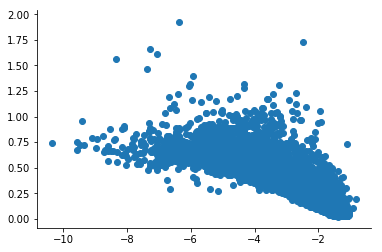

In [5]:
plt.scatter(res.mean(), res.var());

In [6]:
idx = res.var().sort_values(ascending=False).head(1000).index

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [8]:
pca = PCA()
Y = pca.fit_transform(scale(res[idx], 1))

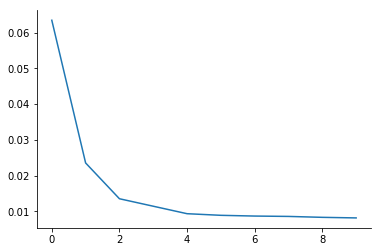

In [9]:
plt.plot(pca.explained_variance_ratio_[:10]);

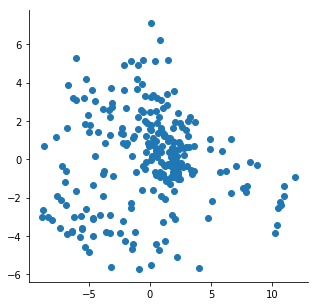

In [10]:
figsize(5, 5)
plt.scatter(Y[:, 0], Y[:, 1]);

In [38]:
from sklearn.mixture import BayesianGaussianMixture

In [39]:
gmm = BayesianGaussianMixture(n_components=20, max_iter=10000)

In [40]:
gmm.fit(Y[:, :2])

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=10000, mean_precision_prior=None, mean_prior=None,
            n_components=20, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

In [41]:
phi_hat = gmm.predict(Y[:, :2])

In [42]:
sample_info['PC1'] = Y[:, 0]
sample_info['PC2'] = Y[:, 1]
sample_info['cluster'] = phi_hat

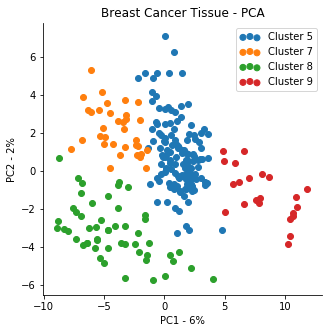

In [43]:
figsize(5, 5)
for i, g in sample_info.groupby('cluster'):
    plt.scatter(g.PC1, g.PC2, label=f'Cluster {i}')
    
plt.xlabel('PC1 - {:.0%}'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 - {:.0%}'.format(pca.explained_variance_ratio_[1]))

plt.legend(scatterpoints=3);
plt.title('Breast Cancer Tissue - PCA');
plt.savefig('PCA_MOB.pdf');

In [44]:
gmm

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=10000, mean_precision_prior=None, mean_prior=None,
            n_components=20, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

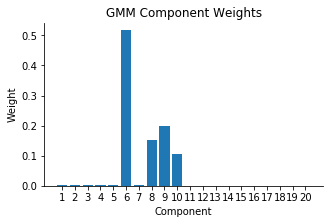

In [45]:
figsize(5, 3)
plt.bar(range(len(gmm.weights_)), gmm.weights_);
plt.title('GMM Component Weights');
plt.xticks(range(0, 20), range(1, 20 + 1));
plt.xlabel('Component')
plt.ylabel('Weight');
plt.savefig('gmm-weights.pdf')

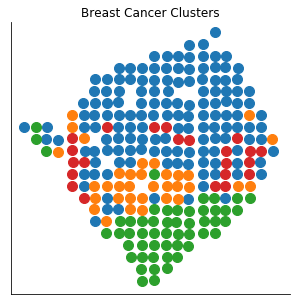

In [46]:
figsize(5, 5)
for i, g in sample_info.groupby('cluster'):
    plt.scatter(g.x, g.y, label=f'Cluster {i}', s=100)
    
plt.xticks([])
plt.yticks([]);
plt.axis('equal');
plt.title('Breast Cancer Clusters');
plt.savefig('bc_clusters.pdf');

In [47]:
sample_info['cluster'] = phi_hat

In [48]:
de_results = NaiveDE.lr_tests(sample_info, res.T, '~ C(cluster)')

In [49]:
de_results.query('qval < 0.05').shape

(909, 6)

In [50]:
de_results.shape

(12856, 6)

In [68]:
results = pd.read_csv('BC_final_results.csv', index_col=0)

results['pval'] = results['pval'].clip_lower(results.query('pval > 0')['pval'].min() / 2)
results['qval'] = results['qval'].clip_lower(results.query('qval > 0')['qval'].min() / 2)

sde_results = results

In [69]:
de_results = de_results.sort_index()
sde_results = sde_results.sort_values('g')

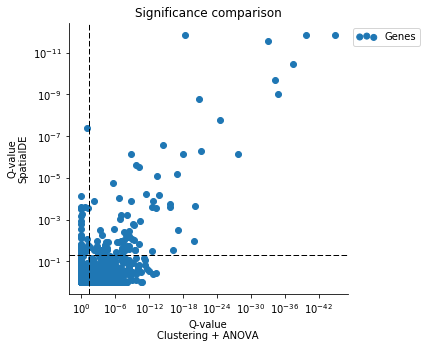

In [70]:
figsize(5, 5)

plt.loglog()
plt.scatter(de_results['qval'], sde_results['qval'], rasterized=True, label='Genes');
ax = plt.gca()
ax.invert_yaxis()
ax.invert_xaxis();
plt.xlabel('Q-value\nClustering + ANOVA')
plt.ylabel('Q-value\nSpatialDE');

plt.axhline(0.05, color='k', ls='--', lw=1)
plt.axvline(0.05, color='k', ls='--', lw=1);

plt.legend(scatterpoints=3, bbox_to_anchor=[1, 1])

plt.title('Significance comparison')
plt.savefig('BC_significance_comparison.pdf', bbox_inches='tight')

In [71]:
sde_results.query('qval < 0.05').shape

(115, 18)

In [72]:
sig_genes = sde_results.query('qval < 0.05')['g'].sort_values().values
more_sig = de_results.loc[sig_genes].query('qval > 0.05').sort_values('qval')
more_sig

,Intercept,C(cluster)[T.7],C(cluster)[T.8],C(cluster)[T.9],pval,qval
IL12RB1,-1.403751,0.112185,-0.019430,-0.042186,0.000280,0.069915
ITIH2,-2.818349,-0.137417,-0.362593,-0.009470,0.000319,0.079782
SNAP25,-1.381974,0.131561,-0.016915,-0.036725,0.000377,0.094320
TFF1,-2.049579,-0.132430,-0.176715,0.190379,0.000413,0.103253
LRRC15,-2.597737,0.133830,0.338372,-0.206883,0.000603,0.150864
AGT,-4.607056,-0.331284,0.381600,0.404957,0.001025,0.256171
SAA1,-1.590728,-0.235613,-0.416423,-0.118255,0.001249,0.312167
HPS3,-1.946380,-0.061307,-0.019514,0.270664,0.001438,0.359582
CXCL9,-2.663973,0.275227,0.099889,-0.301602,0.003218,0.804554
SLC16A6,-1.603662,-0.021899,-0.065936,0.084704,0.051414,1.000000


In [73]:
more_sig.shape

(32, 6)

In [74]:
for g in sde_results.query('qval < 0.05').g:
    print(g)

ACTL8
ADAMTS2
AEBP1
AGT
ANTXR1
ASPN
AZGP1
B2M
BASP1
BEX1
BST2
C1S
C2orf40
C3
CCDC80
CILP
CLEC3A
COL10A1
COL11A1
COL12A1
COL1A1
COL1A2
COL3A1
COL5A1
COL5A2
COL6A3
COX6B1
CRISPLD2
CST1
CST3
CST4
CTHRC1
CTSD
CTSK
CXCL13
CXCL9
DBI
DCN
EEF1A2
ETV7
FCGR3A
FGB
FGG
FN1
FXYD3
GBP1
GHRH
GJA1
GPC3
GPIHBP1
HLA-DRA
HMCN1
HMGCS2
HPN
HPS3
HTRA1
IGFBP5
IGLL5
IL12RB1
IL21R
ITGAX
ITIH2
KLHL15
LOX
LRRC15
LUM
LY6E
MAFB
MMP10
MMP11
MMP13
PALLD
PAQR8
PEG10
PI15
PNMT
POSTN
PPP1R1B
PRRX1
PRSS23
RARRES1
RPL13
RPL28
RPL29
RPL41
RPL8
SAA1
SERPINA5
SFRP2
SLC16A6
SLX4
SMYD1
SNAP25
SOD2
SPARC
SPINT2
SPP1
SSPO
STARD10
STC2
SULF1
TFF1
TFF3
TGM2
THBS2
TMSB4X
TNC
TP53INP2
TYW5
VCAN
VIM
WDR5B
WFDC2
ZNF280C
ZNF880


In [75]:
sde_results.query('g in @more_sig.index')[['g', 'l', 'qval']].sort_values('qval')

,g,l,qval
7824,SNAP25,0.641736,4.121108e-08
8876,CLEC3A,1.843940,7.170456e-05
11370,AGT,3.125663,2.500246e-04
9594,STC2,1.843940,2.500246e-04
8827,IL12RB1,1.087806,2.764643e-04
11263,PI15,3.125663,2.897039e-04
9926,SMYD1,1.843940,3.063606e-04
8463,CXCL9,1.087806,5.226403e-04
9020,IGFBP5,1.843940,6.902424e-04
7422,SSPO,0.641736,1.163649e-03


In [76]:
more_sig.shape

(32, 6)

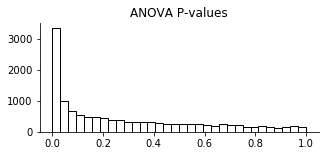

In [77]:
figsize(5, 2)
de_results.pval.hist(bins=32, fc='w', ec='k', grid=False);
plt.title('ANOVA P-values');

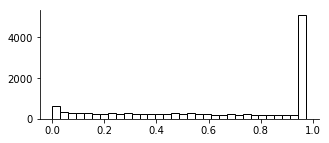

In [78]:
figsize(5, 2)
sde_results.pval.hist(bins=32, fc='w', ec='k', grid=False);

In [79]:
114 - 32

82